# Latin Hypercube Sampling in MUSICA
In the example above, all the grid cells contain the exact same information about environment parameters and species concentrations.</br>
Therefore, there is no variance regarding the solutions among different grid cells and this is not practically useful.</br>
In reality, users may want to vary the conditions for each grid cell and study how the chemical system evolves along with the time differently.</br>
They can manipulate the values completely randomly but this may lead to a meaningless initial condition or an unstable chemical system to solve.</br>
Latin Hypercube Sampling (LHS) is a statistical method for generating multidimensional random samples.</br>
It avoids the problem of clustering that can sometimes appear in pure random sampling.</br>
This tutorial will go over a simple example of utilizing LHS to run a multi-grid-cell solver in MUSICA.</br>
For documentation on Latin Hypercube Sampling, go [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.LatinHypercube.html).

## 1. Importing Libraries
Below is a list of the required libraries for this tutorial:

In [1]:
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
from scipy.stats import qmc
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', str) # This is done to make the arrays more readable
np.set_printoptions(suppress=True) # This is done to make the arrays more readable

## 2. Rerunning Previous Code
This is simply a copy of the first 4 steps from the [Multiple Grid Cells Tutorial](4.%20multiple_grid_cells.ipynb) since the code is identical aside from the number of grid cells being increased.</br>
If you would like to view the explanation for this code, refer to the hyperlink on the above line.

In [2]:
A = mc.Species(name="A")
B = mc.Species(name="B")
C = mc.Species(name="C")
species = [A, B, C]
gas = mc.Phase(name="gas", species=species)

r1 = mc.Arrhenius(
    name="A_to_B",
    A=4.0e-3,  # Pre-exponential factor
    C=50,      # Activation energy (units assumed to be K)
    reactants=[A],
    products=[B],
    gas_phase=gas
)

r2 = mc.Arrhenius(
    name="B_to_C",
    A=4.0e-3,
    C=50,  
    reactants=[B],
    products=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism(
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2]
)

solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

num_grid_cells = 100
state = solver.create_state(num_grid_cells)

## 3. Creating and Scaling a Latin Hypercube Sampler
This Latin Hypercube Sampler uses the same 5 dimensions as the [Multiple Grid Cells Tutorial](4.%20multiple_grid_cells.ipynb) to randomize each of the individual systems, being:
* temperature (Kelvin),
* pressure (Pascals), and
* the concentrations of each of the species (mol/m<sup>3</sup>).

Next, the LHS is created with the provided number of dimensions with a randomized sample that will be scaled by the sampler.</br>
The upper and lower bounds for each of the five dimensions are then set, and the sample is scaled with those bounds by the LHS.</br>
Do note as before that the ordering inside the bounding arrays matters and cannot be changed.

In [3]:
ndim = 5
nsamples = num_grid_cells

# Create a Latin Hypercube sampler in the unit hypercube
sampler = qmc.LatinHypercube(d=ndim)

# Generate samples
sample = sampler.random(n=nsamples)

# Define bounds for each dimension
l_bounds = [275, 100753.3, 0, 0, 0] # Lower bounds
u_bounds = [325, 101753.3, 10, 10, 10] # Upper bounds

# Scale the samples to the defined bounds
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

## 4. Splitting up the Array Output and Running the Solver
This code follows the same flow as the [Multiple Grid Cells Tutorial](4.%20multiple_grid_cells.ipynb) but with the new LHS values.</br>
The only notable change is the old <i>box_model_values</i> array becoming the <i>sample_scaled</i> output array from the LHS.

In [4]:
temperatures = sample_scaled[:, 0]
pressures = sample_scaled[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = sample_scaled[:, 2]
concentrations["B"] = sample_scaled[:, 3]
concentrations["C"] = sample_scaled[:, 4]

state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 60
curr_time = 0

while curr_time <= sim_length:
    solver.solve(state, curr_time)
    concentrations_solved.append(state.get_concentrations())
    curr_time += time_step_length

## 5. Expanding out the DataFrame
The intention of this code snippet is to split up each grid cell for each time step onto a separate row in the DataFrame so they can be averaged when plotted.</br>
This will produce a confidence interval for each time step since there will be a set of unique values at every time step for each species.</br>
As an example, if there are 2 grid cells and 5 time steps, the data table will have 10 rows, with the first being the first grid cell for the first time step, the second row being the second grid cell for the first time step, the third row being the first grid cell for the second time step, and so on.</br>
You can see this pattern in the displayed DataFrame as well.</br>
After the expansion of the DataFrame, adding the other columns is fairly similar; they are simply given more rows since the number of rows is now the product of the number of grid cells and the number of time steps.</br>
The time column is notably different, however, since each time step has to be repeated for every grid cell.</br>
Once that is all done, the expanded DataFrame is displayed. Note that the first column is the index of the DataFrame, not the time step here.

In [5]:
concentrations_solved_expanded = []
time = []
for i in range(0, sim_length + 1, time_step_length):
    for j in range(0, num_grid_cells):
        concentrations_solved_expanded.append({key: value[j] for key, value in concentrations_solved[int(i/time_step_length)].items()})
        time.append(i)
df_expanded = pd.DataFrame(concentrations_solved_expanded)
df_expanded = df_expanded.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
df_expanded['time.s'] = time
df_expanded['ENV.temperature.K'] = np.repeat(temperatures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.pressure.Pa'] = np.repeat(pressures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded = df_expanded[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
display(df_expanded)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0,309.7276608274192,101704.16497576218,39.49340335509994,1.8303166565657936,0.5582799990116556,7.505023274688886
1,0,309.7276608274192,101704.16497576218,39.49340335509994,0.10900148612825294,4.7041909379335936,2.8369484950718205
2,0,309.7276608274192,101704.16497576218,39.49340335509994,0.7893181165212338,7.692856761200801,5.479266737727308
3,0,309.7276608274192,101704.16497576218,39.49340335509994,4.14654462686305,2.9064714790294497,9.718544736597146
4,0,309.7276608274192,101704.16497576218,39.49340335509994,9.168507779900754,1.0452618789561743,2.3938272421305555
...,...,...,...,...,...,...,...
6095,60,309.7276608274192,101704.16497576218,39.49340335509994,0.00027803476818283627,0.003847549196587605,16.46203270150234
6096,60,309.7276608274192,101704.16497576218,39.49340335509994,0.0004604018465094205,0.005260220686453089,14.648738591753022
6097,60,309.7276608274192,101704.16497576218,39.49340335509994,0.0009738277341721631,0.009950086229990268,20.221407581108544
6098,60,309.7276608274192,101704.16497576218,39.49340335509994,0.0008384210450644092,0.007246355220872357,7.868645647524955


## 6a. Visualizing the Results (Confidence Interval)
Here, the three species are plotted out with Seaborn's <i>lineplot()</i> function, which takes in an input x and y variable with the 95% confidence interval (CI) displayed.</br>
There are additional parameters passed in as well, such as the CI value, which can be changed from 95, and setting the alpha so that the CI is more visible.</br>
Since the DataFrame has more than one value for each time step (x-axis), the solid line represents the mean of the species' concentrations at every time step.

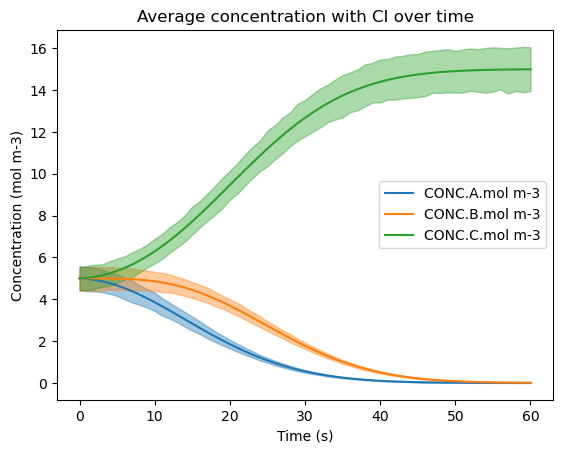

In [6]:
sns.lineplot(data=df_expanded, x='time.s', y='CONC.A.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.A.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.B.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.B.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.C.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.C.mol m-3')
plt.title('Average concentration with CI over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='center right')
plt.show()

## 6b. Visualizing the Results (Min-Max Curve)
This figure is similar to the CI curve, but it instead displays the range of values for each species at each time step.</br>
To build this figure, the min and max at every time step are found and populated into their respective arrays to represent the bottom curve and top curve for each species.</br>
All of the curves are then plotted for each species with a lower alpha so that the overlaps are visible.

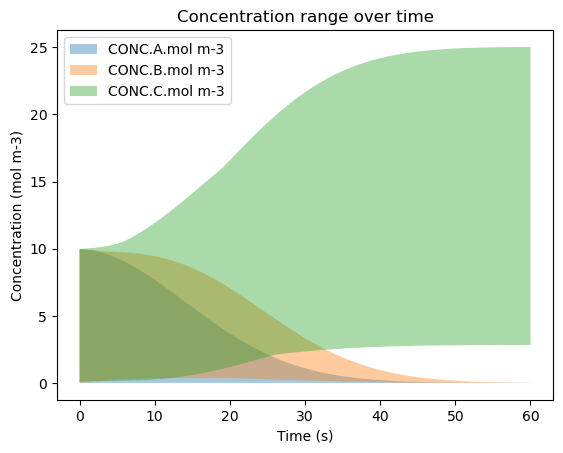

In [7]:
min_y = []
max_y = []
for i in range(0, sim_length + 1, time_step_length):
        min_y.append({key: np.min(value) for key, value in concentrations_solved[int(i/time_step_length)].items()})
        max_y.append({key: np.max(value) for key, value in concentrations_solved[int(i/time_step_length)].items()})
time_x = list(map(float, range(0, sim_length + 1, time_step_length)))

plt.fill_between(time_x, [y['A'] for y in min_y], [y['A'] for y in max_y], alpha = 0.4, label='CONC.A.mol m-3')
plt.fill_between(time_x, [y['B'] for y in min_y], [y['B'] for y in max_y], alpha = 0.4, label='CONC.B.mol m-3')
plt.fill_between(time_x, [y['C'] for y in min_y], [y['C'] for y in max_y], alpha = 0.4, label='CONC.C.mol m-3')
plt.title('Concentration range over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

## 7a. Defining User Defined Reactions
MUSICA supports what are called User Defined reactions, which are a more flexible type of reaction that supports defining per-grid-cell reaction rates.</br>
Do note that both Emission and First Order Loss reactions are considered as User Defined reactions under the hood.</br>
This code cell defines 3 new reactions: one User Defined, one Emission, and one First Order Loss.</br>
It then creates a new mechanism containing both the old reactions from step 2 of this tutorial as well as the 3 new reactions.

In [8]:
r3 = mc.UserDefined(
    name="complex_rxn",
    scaling_factor=1.0,
    reactants=[A, (2, B)],
    products=[A, (2, C), B],
    gas_phase=gas
)

r4 = mc.Emission(
    name="B_emission",
    scaling_factor=1.0,
    products=[B],
    gas_phase=gas
)

r5 = mc.FirstOrderLoss(
    name="C_loss",
    scaling_factor=1.0,
    reactants=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism(
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2, r3, r4, r5]
)

## 7b. Creating the Solver, State, and Latin Hypercube Sampler
This code is a rehash that includes code similar to steps 2 through 4, just with the LHS being expanded to 8 dimensions to account for the 3 new User Defined reactions. 

In [9]:
solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

num_grid_cells = 100
state = solver.create_state(num_grid_cells)

ndim = 8
nsamples = num_grid_cells

# Create a Latin Hypercube sampler in the unit hypercube
sampler = qmc.LatinHypercube(d=ndim)

# Generate samples
sample = sampler.random(n=nsamples)

# Define bounds for each dimension
l_bounds = [275, 100753.3, 0, 0, 0, 0, 0, 0] # Lower bounds
u_bounds = [325, 101753.3, 20, 10, 20, 1, 0.5, 0.5] # Upper bounds

# Scale the samples to the defined bounds
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

temperatures = sample_scaled[:, 0]
pressures = sample_scaled[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = sample_scaled[:, 2]
concentrations["B"] = sample_scaled[:, 3]
concentrations["C"] = sample_scaled[:, 4]

## 7c. Creating and Setting the User Defined Parameters
Next, each of the new reactions is given a dictionary with a name as the key and their respective LHS outputs as the value.</br>
For these reactions, the name must match the name given to the reactions above, with an added prefix, being:
* "USER." for User Defined reactions,
* "EMIS." for Emission reactions, and
* "LOSS." for First Order Loss reactions.</br>

After that, the state's <i>set_user_defined_rate_parameters()</i> function is called to add all of the reaction rates to the system.

In [10]:
complex_rates = {"USER.complex_rxn": sample_scaled[:, 5]}
emission_rates = {"EMIS.B_emission": sample_scaled[:, 6]}
loss_rates = {"LOSS.C_loss": sample_scaled[:, 7]}

state.set_user_defined_rate_parameters(complex_rates)
state.set_user_defined_rate_parameters(emission_rates)
state.set_user_defined_rate_parameters(loss_rates)

## 7d. Setting the Conditions, Running the Solver, and Visualizing the Data
As with step 7b, this is a copy of some previous steps in this tutorial, being steps 4 through 6b this time, with the only change being the simulation length being extended to 100 seconds.</br>
Note the extreme difference in the concentration curves after the 3 new reactions were added; B is now the dominant species instead of C after approximately 50 seconds of the simulation taking place.

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0,294.83543959719435,101278.25678188527,41.314485376727404,16.602362421925122,9.114306377296607,11.862922449784676
1,0,294.83543959719435,101278.25678188527,41.314485376727404,5.288318903767984,5.525783619079561,9.001282379661118
2,0,294.83543959719435,101278.25678188527,41.314485376727404,9.882122598181159,2.6069418401428956,6.320008888932108
3,0,294.83543959719435,101278.25678188527,41.314485376727404,1.7243217188767943,9.390221947516036,15.310395596429352
4,0,294.83543959719435,101278.25678188527,41.314485376727404,1.5777281133659518,4.43971273382291,18.2031072784691
...,...,...,...,...,...,...,...
10095,100,294.83543959719435,101278.25678188527,41.314485376727404,3.9033820219482404e-10,27.61997839663982,0.5260908738714148
10096,100,294.83543959719435,101278.25678188527,41.314485376727404,7.813579131810678e-10,6.322990807491229,0.10607957275864471
10097,100,294.83543959719435,101278.25678188527,41.314485376727404,2.4637086463530907e-10,75.2963039969857,3.4808289957156417
10098,100,294.83543959719435,101278.25678188527,41.314485376727404,3.626569285702381e-10,64.6970842365372,0.6689781999787321


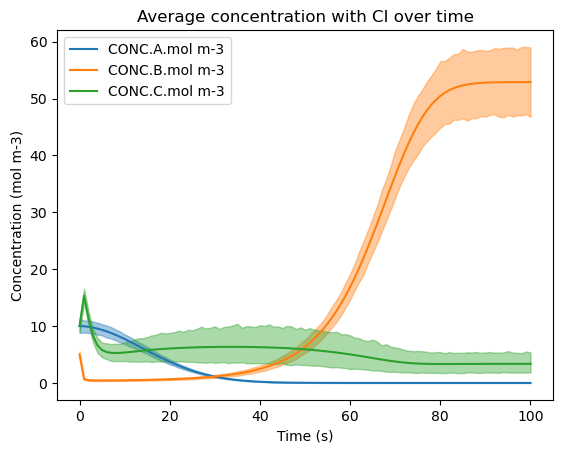

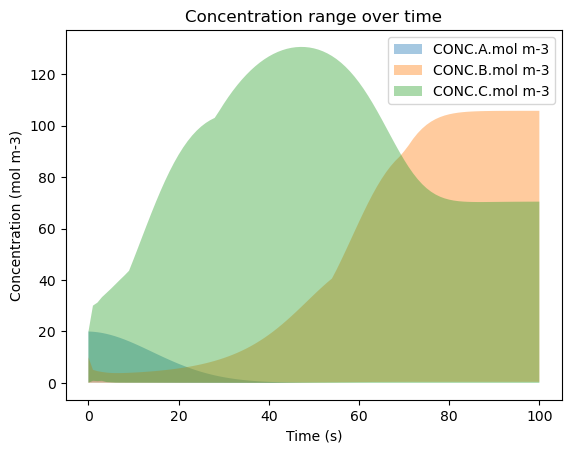

In [11]:
state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 100
curr_time = 0

while curr_time <= sim_length:
    solver.solve(state, curr_time)
    concentrations_solved.append(state.get_concentrations())
    curr_time += time_step_length

concentrations_solved_expanded = []
time = []
for i in range(0, sim_length + 1, time_step_length):
    for j in range(0, num_grid_cells):
        concentrations_solved_expanded.append({key: value[j] for key, value in concentrations_solved[int(i/time_step_length)].items()})
        time.append(i)
df_expanded = pd.DataFrame(concentrations_solved_expanded)
df_expanded = df_expanded.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
df_expanded['time.s'] = time
df_expanded['ENV.temperature.K'] = np.repeat(temperatures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.pressure.Pa'] = np.repeat(pressures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded = df_expanded[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
display(df_expanded)

sns.lineplot(data=df_expanded, x='time.s', y='CONC.A.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.A.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.B.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.B.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.C.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.C.mol m-3')
plt.title('Average concentration with CI over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

min_y = []
max_y = []
for i in range(0, sim_length + 1, time_step_length):
        min_y.append({key: np.min(value) for key, value in concentrations_solved[int(i/time_step_length)].items()})
        max_y.append({key: np.max(value) for key, value in concentrations_solved[int(i/time_step_length)].items()})
time_x = list(map(float, range(0, sim_length + 1, time_step_length)))

plt.fill_between(time_x, [y['A'] for y in min_y], [y['A'] for y in max_y], alpha = 0.4, label='CONC.A.mol m-3')
plt.fill_between(time_x, [y['B'] for y in min_y], [y['B'] for y in max_y], alpha = 0.4, label='CONC.B.mol m-3')
plt.fill_between(time_x, [y['C'] for y in min_y], [y['C'] for y in max_y], alpha = 0.4, label='CONC.C.mol m-3')
plt.title('Concentration range over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()